<a href="https://colab.research.google.com/github/seecode4/seeRepo1/blob/main/mec2-projects/Student_MLE_MiniProject_Fine_Tuning/Student_MLE_MiniProject_Fine_Tuning_m3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import resize_images
from sklearn.model_selection import train_test_split

from tensorflow import keras as K
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.layers import Input, Lambda, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.initializers import RandomNormal, RandomUniform

In [3]:
# Load the CIFAR-10 dataset
cifar_home = 'https://www.cs.toronto.edu/~kriz/cifar.html'
# from tensorflow.keras.datasets import cifar10
%cd /content
!pwd
!rm -fr cifar*
!ls
print('---------')
(x_train_val, y_train_val), (x_test, y_test) = cifar10.load_data()
assert x_train_val.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train_val.shape == (50000, 1)
assert y_test.shape == (10000, 1)
print(f'x_train_val type: {type(x_train_val)}, ndim:{x_train_val.ndim}, shape:{x_train_val.shape}')
print(f'{x_train_val[0][0][0:10]}')

/content
/content
sample_data
---------
x_train_val type: <class 'numpy.ndarray'>, ndim:4, shape:(50000, 32, 32, 3)
[[ 59  62  63]
 [ 43  46  45]
 [ 50  48  43]
 [ 68  54  42]
 [ 98  73  52]
 [119  91  63]
 [139 107  75]
 [145 110  80]
 [149 117  89]
 [149 120  93]]


In [4]:
# One-hot encode the labels - with to_categorical
num_classes = 10
y_train_val_1hot = to_categorical(y_train_val, num_classes)
y_test_1hot= to_categorical(y_test, num_classes)
print(y_train_val_1hot.shape, y_test_1hot.shape)

(50000, 10) (10000, 10)


In [5]:
# Normalize the pixel values to [0, 1]
np.set_printoptions(precision=4)
X_train_val = x_train_val/255
print(f'X_train_val:\n {X_train_val[0][0][0:10]}...')
X_test = x_test/255
print(f'X_test:\n {X_test[0][0][0:10]}...')

X_train_val:
 [[0.2314 0.2431 0.2471]
 [0.1686 0.1804 0.1765]
 [0.1961 0.1882 0.1686]
 [0.2667 0.2118 0.1647]
 [0.3843 0.2863 0.2039]
 [0.4667 0.3569 0.2471]
 [0.5451 0.4196 0.2941]
 [0.5686 0.4314 0.3137]
 [0.5843 0.4588 0.349 ]
 [0.5843 0.4706 0.3647]]...
X_test:
 [[0.6196 0.4392 0.1922]
 [0.6235 0.4353 0.1843]
 [0.6471 0.4549 0.2   ]
 [0.651  0.4627 0.2078]
 [0.6275 0.4392 0.1804]
 [0.6118 0.4275 0.1608]
 [0.6353 0.451  0.1843]
 [0.6235 0.4431 0.1765]
 [0.6196 0.4353 0.1725]
 [0.6235 0.4431 0.1608]]...


In [6]:
# Config to make results repeatable/deterministic
tf.config.experimental.enable_op_determinism()
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [7]:
base_model = VGG16(
    weights='imagenet',  # load weights pretrained on ImageNet
    include_top=False,   # exclude the top classifier
    input_shape=(32, 32, 3),
    pooling='max'        # add a global max pooling layer after each layer
)
# Freeze the the trainable param (weights and biases) so they are not retrained
for layer in base_model.layers:
   layer.trainable = False
# print(base_model.summary())

model3a = Sequential()
initializer = RandomNormal(mean=0.0, stddev=1.0, seed=SEED)
# input = Input(shape=(32, 32, 3))
for layer in base_model.layers[:-6]:
    model3a.add(layer)

model3a.add(Conv2D(filters=32, kernel_size=7, padding='same'))
model3a.add(Flatten())
model3a.add(BatchNormalization())
model3a.add(Dense(256, activation="relu", kernel_initializer='he_normal'))
# model3a.add(GlobalAveragePooling2D(data_format='channels_last'))
# model3a.add(Dense(256, activation="relu", kernel_initializer='he_normal'))

# Try to prevent overfitting
model3a.add(tf.keras.layers.Dropout(.5))
model3a.add(Dense(256, activation="relu", kernel_initializer='he_normal'))

# Add the final classification layer with 10 units (for CIFAR-10 classes) and softmax activation
model3a.add(Dense(10, activation='softmax', kernel_initializer=initializer))

# Compile the model - use Adagrad optimizer
model3a.compile(Adagrad(learning_rate=0.001, use_ema=True, ema_momentum=0.9),
               loss='categorical_crossentropy', metrics=['accuracy'])
print(model3a.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

In [ ]:
# # Data Augmentation
# datagen_aug = ImageDataGenerator(rotation_range=20,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              horizontal_flip=True
#                              )
# datagen_aug.fit(X_train_val)

In [8]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
# def lr_scheduler(epoch):
#     return 0.002 * (0.5 ** (epoch // 20))
# reduce_lr = LearningRateScheduler(lr_scheduler)

# Define a callback to monitor val_accuracy
monitor_acc = EarlyStopping(monitor='accuracy',
                       min_delta=0.001, patience=4)

# Train the model
print(X_train_val.shape, y_train_val_1hot.shape)
history3a = model3a.fit(X_train_val, y_train_val_1hot, epochs=50, batch_size=64,
          validation_split=0.2, validation_freq=1, verbose=1,
          callbacks= [monitor_acc])

(50000, 32, 32, 3) (50000, 10)
Epoch 1/50
625/625 [==============================] - 51s 80ms/step - loss: 7.9612 - accuracy: 0.4753 - val_loss: 3.1321 - val_accuracy: 0.6285
Epoch 2/50
625/625 [==============================] - 49s 78ms/step - loss: 4.3583 - accuracy: 0.5504 - val_loss: 2.3802 - val_accuracy: 0.6465
Epoch 3/50
625/625 [==============================] - 49s 78ms/step - loss: 3.4271 - accuracy: 0.5709 - val_loss: 2.0029 - val_accuracy: 0.6600
Epoch 4/50
625/625 [==============================] - 49s 79ms/step - loss: 2.9001 - accuracy: 0.5884 - val_loss: 1.8250 - val_accuracy: 0.6642
Epoch 5/50
625/625 [==============================] - 49s 78ms/step - loss: 2.5122 - accuracy: 0.5980 - val_loss: 1.6243 - val_accuracy: 0.6687
Epoch 6/50
625/625 [==============================] - 49s 78ms/step - loss: 2.2276 - accuracy: 0.6122 - val_loss: 1.5280 - val_accuracy: 0.6734
Epoch 7/50
625/625 [==============================] - 49s 78ms/step - loss: 2.0709 - accuracy: 0.6145 - v

In [9]:
# Train the model
print(X_train_val.shape, y_train_val_1hot.shape)
model3a.fit(X_train_val, y_train_val_1hot, epochs=50, batch_size=64,
          validation_split=0.2, validation_freq=2, verbose=1,
          callbacks= [monitor_acc])

(50000, 32, 32, 3) (50000, 10)
Epoch 1/50
625/625 [==============================] - 41s 66ms/step - loss: 0.7776 - accuracy: 0.7400
Epoch 2/50
625/625 [==============================] - 50s 79ms/step - loss: 0.7666 - accuracy: 0.7429 - val_loss: 0.8656 - val_accuracy: 0.7241
Epoch 3/50
625/625 [==============================] - 41s 66ms/step - loss: 0.7664 - accuracy: 0.7451
Epoch 4/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7627 - accuracy: 0.7446 - val_loss: 0.8621 - val_accuracy: 0.7247
Epoch 5/50
625/625 [==============================] - 42s 66ms/step - loss: 0.7499 - accuracy: 0.7468
Epoch 6/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7456 - accuracy: 0.7491 - val_loss: 0.8518 - val_accuracy: 0.7285
Epoch 7/50
625/625 [==============================] - 41s 66ms/step - loss: 0.7432 - accuracy: 0.7502
Epoch 8/50
625/625 [==============================] - 49s 78ms/step - loss: 0.7338 - accuracy: 0.7483 - val_loss: 0.8515 - val_ac

In [10]:
# Evaluate the model on the test set
from sklearn.metrics import roc_auc_score, confusion_matrix

y_test_pred = model3a.predict(X_test)
print(y_test_1hot.shape, y_test_pred.shape)

313/313 [==============================] - 11s 33ms/step
(10000, 10) (10000, 10)


In [11]:
test_score = roc_auc_score(y_test_1hot, y_test_pred)
print("roc_auc_score:", test_score)

y_test_pred_val = np.argmax(y_test_pred, axis=1).reshape(-1,)
y_test_val = np.ravel(y_test)
print(y_test_val.shape, y_test_pred_val.shape)
print(type(y_test), type(y_test_pred_val))

cm = confusion_matrix(y_test_val, y_test_pred_val)
print(cm)

roc_auc_score: 0.9615948777777777
(10000,) (10000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[740  20  55  15  51   4   3   9  64  39]
 [ 14 841   5   6  10   7   7   3  20  87]
 [ 37  12 661  35 133  26  54  24   9   9]
 [ 12  24  87 462 107 166  64  36  15  27]
 [  6   3  61  32 796  21  32  37   6   6]
 [ 11   9  58 147  89 599  32  43   4   8]
 [  1  10  41  42  84  25 775   6   7   9]
 [  6   3  23  27 102  57   5 761   0  16]
 [ 30  38  14  10  29   4   2   4 844  25]
 [ 12  89  11  13  13   8   4  13  23 814]]


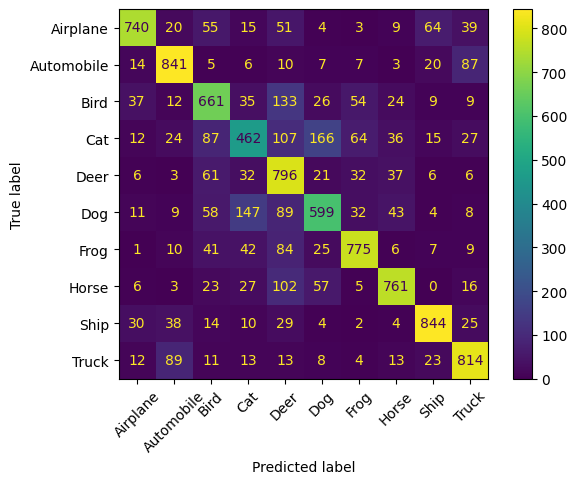

In [12]:
cm_plot_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog',
                  'Frog', 'Horse', 'Ship', 'Truck'] # [range(10)]
# plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

**Summary:**

**Student_MLE_MiniProject_Fine_Tuning_m1_m2.ipynb:**

Loaded the CIFAR-10 dataset using </br>
(x_train_val, y_train_val), (x_test, y_test) = cifar10.load_data() </br>
It has 50000 train images and 10000 test images

Also tried looking at the actual dataset from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz. </br>
This gave an idea of the file organization (as 5 batches of train and 1 batch of test data). </br>
Used the intial load_data() from hereon.

Since this dataset has 10 classes, looked at the unique value counts. It is quite evenly distributed across the 10 classes.

**Model 1:**
The following steps were done to create the model
*   Normalized the pixel values by dividing by 255.
*   Then one hot encoded the target (y) values.
*   Created a base_model with VGG16, without the top layer and input_shape=cifar-10 image shape, (32,32,3)
*   Froze the base_model trainable param (weights and biases) so they are not retrained
*   Created a new model using the all but the last layer of the base_model.
*   Replaced that last layer (global_max_pooling2d) with GlobalAveragePooling2D
*   Set the SEED value and used a kernel initializer based on RandomNormal
*   Added a fully connected (Dense) layer with 256 units and ReLU activation
*   Lastly added the final classification layer with 10 units (for CIFAR-10 classes) and softmax activation

With the model ready, compiled it with
  optimizer Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy']

To train the model, used a validation_split=0.2 epochs=10 batch_size=256,
  got a 25% accuracy and 26% validation accuracy
</br>
</br>
**Model 2:**
With a model similar to the first model, tried the following
*   optimizer Adagrad(weight_decay=5e-4).
*   monitored accuracy for EarlyStopping with min_delta=0.001, patience=4.

To train the model, used a validation_split=0.2 epochs=50 and batch_size=256
With this, the accuracy moved up to 51% and validation accuracy to 53.8% hovering around 53% in the last few epochs.

Drew the Confusion Matrix. See that it picked Ship and Frog best and had most trouble with Bird and Cat.
</br>
</br>

**Model 3: Student_MLE_MiniProject_Fine_Tuning_m3.ipynb:**
Changed kernel_initializer to 'he_normal' for reLU activation. Added a Dropout layer to prevent overfitting. With this got accuracy: 0.7602 - loss: 0.6709 - val_accuracy: 0.5976 - val_loss: 1.3902

Played around a little with Data Augmentation, learning rate scheduler etc, without any significant improvements. Then decided to peel off a few more layers from the VGG16 base model.

**Model 3a: Student_MLE_MiniProject_Fine_Tuning_m3a.ipynb:**
**With base_model.layers[:-6], added the following **
*   Conv2D(filters=32, kernel_size=7, padding='same') (idea being 32*7 = 224)
*   Flatten, BatchNormalization with intent to regularize the output.
*   Dense(256, activation="relu", kernel_initializer='he_normal')
*   Dropout(.5) to aid against Overfitting
*   Dense(256, activation="relu", kernel_initializer='he_normal')
*   Dense(10, activation='softmax', kernel_initializer=initializer) as the final classification layer

Used optimizer Adagrad(learning_rate=0.001, use_ema=True, ema_momentum=0.9)
With this, it showed more improvement with validation accuracy getting close to 73%. Moving along these lines, suspect, it could get to even better results.

Looking at the confusion matrix, it has over 84% accuracy identifying Automobile and Ship and has most issue differentiating
Cat and Dog with accuracies at 46% and 60% respectively.
